<a href="https://colab.research.google.com/github/vitaltavares/MQP2019/blob/master/ImpliedVol_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSM formula

## Abstract

- create GBM class
- define a method for BSM formula for a given option type

## Analysis

BS model assumes the distribution of stock as lognormal. In particular, it writes 
$$\ln \frac{S(T)}{S(0)} \sim \mathcal N((r  - \frac 1 2 \sigma^2) T, \sigma^2 T)$$
with respect to risk neutral measure. In the above, the parameters stand for

* $S(0)$: The initial stock price
* $S(T)$: The stock price at $T$
* $r$: interest rate
* $\sigma$: volatility




The call and put price with maturity $T$ and $K$ will be known as $C_0$ and $P_0$ given as below:
$$C_0 = \mathbb E [e^{-rT} (S(T) - K)^+] = S_0  \Phi(d_1) - K e^{-rT} \Phi(d_2),$$
and 
$$P_0 = \mathbb E [e^{-rT} (S(T) - K)^-] = K e^{-rT} \Phi(- d_2) - S_0  \Phi(- d_1),$$
where $d_i$ are given as
$$d_1 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r + \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right],$$
and
$$d_2 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r - \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right] = d_{1}-\sigma\sqrt{\left( T - t \right)}$$

From $\textit{Stochastic Calculus for Finance II Continuous Time Models}$ by Shreve


Put-call parity will be useful:
    $$C_0 - P_0 =  S(0) - e^{-rT} K.$$


## Code

In [0]:
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt

We reload the european option class created before.

In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype
      self.strike = strike
      self.maturity = maturity
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return np.max([0, (s - k)*otype])
    

Next, we create the gbm class, which is 
determined by three parameters. We shall initialize it
as it  is created.

In [0]:
'''============
Gbm class inherited from sde_1d
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

BSM formula is given by a method of Gbm class with an input of an option.

In [0]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, vanilla_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity)) # Need to be working with maturity minus current time t
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity)) #  But how do we get the current time t
    
    return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

Gbm.bsm_price = bsm_price

In [122]:
'''===============
Test bsm_price
================='''
gbm1 = Gbm()
option1 = VanillaOption()
print('>>>>>>>>>>call value is ' + str(gbm1.bsm_price(option1)))
option2 = VanillaOption(otype=-1)
print('>>>>>>>>>>put value is ' + str(gbm1.bsm_price(option2)))


>>>>>>>>>>call value is 5.943273183452845
>>>>>>>>>>put value is 10.84042522804176


In [0]:
###############
# Arbitrage-Free Model Object-Oriented
#############

class ArbitrageFree:
  def pc_parity(self, vanilla_option1, vanilla_option2, gbm):
    
    call_price = gbm.bsm_price(vanilla_option1)
    put_price = gbm.bsm_price(vanilla_option2)
    k = vanilla_option1.strike  #Note: Put and Call with same strike k
    r = gbm.drift_ratio     #and interest r
    maturity = vanilla_option1.maturity #and maturity
    s0 = gbm.init_state

    #give some space for machine precision error
    if call_price - put_price + np.exp(-(r*maturity)) - s0 <= 10^(-10): 
      return ">>>>>>>>>Option is arbitrage-free"
    else:
      return ">>>>>>>>>Option is not arbitrage-free"
  
  
  

In [133]:
'''===============
Test Arbitrage Free Model
================='''

arb_free = ArbitrageFree()
arb_free.pc_parity(option1, option2, gbm1)

'>>>>>>>>>Option is arbitrage-free'

In [0]:
'''===============
Define Greeks
================='''

class Greek:
  
  #First time the current price of stock will affect equation
  #Choose arbitrary price of 112
  def __init__(self, s = 112.):
    self.s = s
               
             
  def delta(self,vanilla_option, gbm):
    otype = vanilla_option.otype
    maturity = vanilla_option.maturity
    k = vanilla_option.strike
    
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity))
    
    if otype == 1:
      return ss.norm.cdf(d1)
    else:
      return ss.norm.cdf(d1) - 1
               
    
  def gamma(self,vanilla_option, gbm):
    otype = vanilla_option.otype
    maturity = vanilla_option.maturity
    k = vanilla_option.strike
    
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    s = self.s
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity))
    
    return ss.norm.pdf(d1) / (s * sigma * np.sqrt(maturity))
  
  
  def vega(self,vanilla_option, gbm):
    otype = vanilla_option.otype
    maturity = vanilla_option.maturity
    k = vanilla_option.strike
    
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    s = self.s
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity))
    
    return ss.norm.pdf(d1) * s * np.sqrt(maturity)
  
  
  def theta(self,vanilla_option, gbm):
    otype = vanilla_option.otype
    maturity = vanilla_option.maturity
    k = vanilla_option.strike
    
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    s = self.s
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity))
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity))
    
    if otype == 1:
      return (-s * ss.norm.pdf(d1) * sigma / (2 * np.sqrt(maturity))) - (r * k * np.exp(-r * maturity) * ss.norm.cdf(d2))
    else:
      return (-s * ss.norm.pdf(d1) * sigma / (2 * np.sqrt(maturity))) + (r * k * np.exp(-r * maturity) * ss.norm.cdf(-d2))
    
    
  def rho(self,vanilla_option, gbm):
    otype = vanilla_option.otype
    maturity = vanilla_option.maturity
    k = vanilla_option.strike
    
    s0 = gbm.init_state
    sigma = gbm.vol_ratio
    r = gbm.drift_ratio
    
    s = self.s
    
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity))
    
    if otype == 1:
      return k * ss.norm.cdf(d2) * maturity * np.exp(-r * maturity)
    else:
      return -k * ss.norm.cdf(-d2) * maturity * np.exp(-r * maturity)

In [135]:
'''===============
Test Arbitrage Free Model
================='''
greek = Greek()

#Delta
call_delta = greek.delta(option1, gbm1)
put_delta = greek.delta(option2, gbm1)
print(">>>>>>The Call Delta is " + str(call_delta))
print(">>>>>>The Put Delta is " + str(put_delta))

#Gamma
option_gamma = greek.gamma(option1,gbm1)
print(">>>>>>The Option's Gamma is " + str(option_gamma))

#Vega
option_vega = greek.vega(option1, gbm1)
print(">>>>>>The Option's Vega is " + str(option_vega))

#Theta
call_theta = greek.theta(option1, gbm1)
put_theta = greek.theta(option2, gbm1)
print(">>>>>>The Call Theta is " + str(call_theta))
print(">>>>>>The Put Theta is " + str(put_theta))

#Rho
call_rho = greek.rho(option1, gbm1)
put_rho = greek.rho(option2, gbm1)
print(">>>>>>The Call Rho is " + str(call_rho))
print(">>>>>>The Put Rho is " + str(put_rho))


>>>>>>The Call Delta is 0.44470496404281507
>>>>>>The Put Delta is -0.5552950359571849
>>>>>>The Option's Gamma is 0.01763857404142207
>>>>>>The Option's Vega is 44.25165455511969
>>>>>>The Call Theta is -6.25520855850133
>>>>>>The Put Theta is -1.2725938363833578
>>>>>>The Call Rho is 38.52722322082866
>>>>>>The Put Rho is -66.36992882376025


In [0]:
'''===============
Implied Volatility Calculation through Newton Method divident paying asset
================='''

class ImpliedVolatility:
  def __init__(self, q=0):
    self.q = q
  
  def newtonImpliedVolCalc(self, vanillaoption, gbm, greek, marketprice):
    otype = vanillaoption.otype
    maturity = vanillaoption.maturity
    k=vanillaoption.strike

    r = gbm.drift_ratio
    sigma = gbm.vol_ratio
    s0 = gbm.init_state

    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity))
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity))

    vega = greek.vega(vanillaoption, gbm)
    
    optionprice = gbm.bsm_price(vanillaoption)
  

    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
    
    while abs(xnew - xold) > tolerance:
      xold = xnew
      xnew = (xnew - ((optionprice - marketprice) / vega))
      return abs(xnew)

    


    




In [146]:
'''===============
Test Arbitrage Free Model
================='''

impliedVol = ImpliedVolatility()

impliedVolCall = impliedVol.newtonImpliedVolCalc(option1, gbm1, greek, 5.94)
impliedVolPut = impliedVol.newtonImpliedVolCalc(option2, gbm1, greek, 10.84)

print('>>>>>>>>> The Implied Volatility of the Call Option is ' + str(impliedVolCall))
print('>>>>>>>>> The Implied Volatility of the Put Option is ' + str(impliedVolPut))

>>>>>>>>> The Implied Volatility of the Call Option is 0.19992603251820185
>>>>>>>>> The Implied Volatility of the Put Option is 0.1999903906860425


>>>>>>>>>> [0.13213195724214155, 0.13235793749306174, 0.13258391774398195, 0.13280989799490217, 0.13303587824582236, 0.13326185849674255, 0.13348783874766276, 0.13371381899858298, 0.13393979924950317, 0.13416577950042335, 0.13439175975134354, 0.13461774000226379, 0.13484372025318397, 0.13506970050410416, 0.13529568075502435, 0.13552166100594457, 0.13574764125686478, 0.13597362150778497, 0.13619960175870516, 0.13642558200962535, 0.1366515622605456, 0.13687754251146578, 0.13710352276238597, 0.13732950301330615, 0.13755548326422637, 0.13778146351514658, 0.13800744376606677, 0.13823342401698696, 0.13845940426790718, 0.1386853845188274, 0.13891136476974758, 0.13913734502066777, 0.13936332527158798, 0.13958930552250817, 0.1398152857734284, 0.14004126602434858, 0.1402672462752688, 0.14049322652618898, 0.1407192067771092, 0.14094518702802938, 0.14117116727894957, 0.1413971475298698, 0.14162312778079, 0.1418491080317102, 0.14207508828263038, 0.1423010685335506, 0.14252704878447078, 0.1427530290

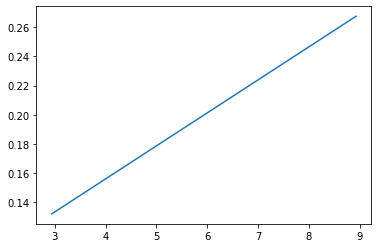

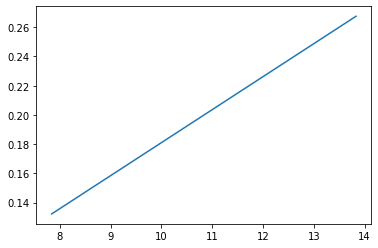

In [147]:
'''===============
Plot Volatility Smile
================='''
marketpriceCall = 5.94
marketpricePut = 10.84


impliedVolCallArray = []
for i in [j for j in range(int(100*(marketpriceCall-3.0)), int(100*(marketpriceCall+3.0)), 1)]:
  k = i * (0.01)
  impliedVolCallArray.append(impliedVol.newtonImpliedVolCalc(option1, gbm1, greek, k))

impliedVolPutArray = []
for i in [j   for j in range(int(100*(marketpricePut-3.0)), int(100*(marketpricePut+3.0)), 1)]:
  k = float(i) * (0.01)
  impliedVolPutArray.append(impliedVol.newtonImpliedVolCalc(option2, gbm1, greek, k))

callpriceRange = []
for i in [j   for j in range(int(100*(marketpriceCall-3.0)), int(100*(marketpriceCall+3.0)), 1)]:
  k = float(i) * (0.01)
  callpriceRange.append(k)

putpriceRange = []
for i in [j   for j in range(int(100*(marketpricePut-3.0)), int(100*(marketpricePut+3.0)), 1)]:
  k = float(i) * (0.01)
  putpriceRange.append(k)

print(">>>>>>>>>>", impliedVolCallArray)
print(">>>>>>>>>>", impliedVolPutArray)
print(">>>>>>>>>>", callpriceRange)
plt.plot(callpriceRange, impliedVolCallArray)
plt.show()
plt.plot(putpriceRange, impliedVolPutArray)
plt.show()